# Eye State Classifier - Error Analysis

Focus: Visualize failing cases and analyze error patterns by metadata (glasses, lighting, etc.)

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

OUTPUT_DIR = Path(r'D:\sim-bench\outputs\eye_state\cpu_run')
DATA_DIR = Path(r'D:\DataSets\mrl')

In [2]:
# Load best epoch predictions
with open(OUTPUT_DIR / 'training_history.json') as f:
    history = json.load(f)

best_epoch = np.argmax(history['val_f1'])
df = pd.read_parquet(OUTPUT_DIR / 'predictions' / f'val_epoch_{best_epoch:03d}.parquet')

# Parse filename metadata: sXXXX_XXXXX_gender_glasses_reflection_lighting_sensor_XX.png
def parse_filename(fn):
    parts = Path(fn).stem.split('_')
    return {
        'subject': parts[0] if len(parts) > 0 else None,
        'gender': 'F' if len(parts) > 2 and parts[2] == '1' else 'M',
        'glasses': 'Yes' if len(parts) > 3 and parts[3] == '1' else 'No',
        'reflection': 'Yes' if len(parts) > 4 and parts[4] == '1' else 'No',
        'lighting': int(parts[5]) if len(parts) > 5 and parts[5].isdigit() else None,
    }

meta = df['filename'].apply(parse_filename).apply(pd.Series)
df = pd.concat([df, meta], axis=1)

# Add image path (awake=open=1, sleepy=closed=0)
df['image_path'] = df.apply(
    lambda r: DATA_DIR / 'val' / ('awake' if r['label'] == 1 else 'sleepy') / r['filename'], axis=1
)

print(f"Best epoch: {best_epoch}, Val accuracy: {df['correct'].mean():.2%}")
print(f"Errors: {(~df['correct']).sum()} / {len(df)}")

Best epoch: 25, Val accuracy: 99.13%
Errors: 148 / 16980


## Error Breakdown by Attribute

In [3]:
errors = df[~df['correct']].copy()
errors['error_type'] = errors.apply(
    lambda r: 'FP (pred open, was closed)' if r['pred'] == 1 else 'FN (pred closed, was open)', axis=1
)

print("Error counts by type:")
print(errors['error_type'].value_counts())

print("\nError rate by attribute:")
for attr in ['glasses', 'reflection', 'lighting', 'gender']:
    rates = df.groupby(attr)['correct'].agg(['mean', 'count'])
    rates['error_rate'] = 1 - rates['mean']
    print(f"\n{attr.upper()}:")
    for idx, row in rates.iterrows():
        print(f"  {idx}: {row['error_rate']:.2%} error ({int(row['count'])} samples)")

Error counts by type:
error_type
FP (pred open, was closed)    107
FN (pred closed, was open)     41
Name: count, dtype: int64

Error rate by attribute:

GLASSES:
  No: 0.81% error (12236 samples)
  Yes: 1.03% error (4744 samples)

REFLECTION:
  No: 1.28% error (8389 samples)
  Yes: 0.48% error (8591 samples)

LIGHTING:
  0: 0.83% error (13311 samples)
  1: 0.43% error (1168 samples)
  2: 1.32% error (2501 samples)

GENDER:
  F: 0.81% error (4335 samples)
  M: 0.89% error (12645 samples)


## Visualize Errors

In [4]:
def show_samples(samples_df, title, n_cols=5):
    """Display grid of eye images with predictions."""
    n = len(samples_df)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = np.array(axes).flatten()
    
    for ax, (_, row) in zip(axes, samples_df.iterrows()):
        img = Image.open(row['image_path'])
        ax.imshow(img)
        ax.axis('off')
        
        true_label = 'Open' if row['label'] == 1 else 'Closed'
        pred_label = 'Open' if row['pred'] == 1 else 'Closed'
        conf = row['prob_open'] if row['pred'] == 1 else 1 - row['prob_open']
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf:.0%})\n"
                     f"G:{row['glasses']} L:{row['lighting']}", fontsize=8)
    
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

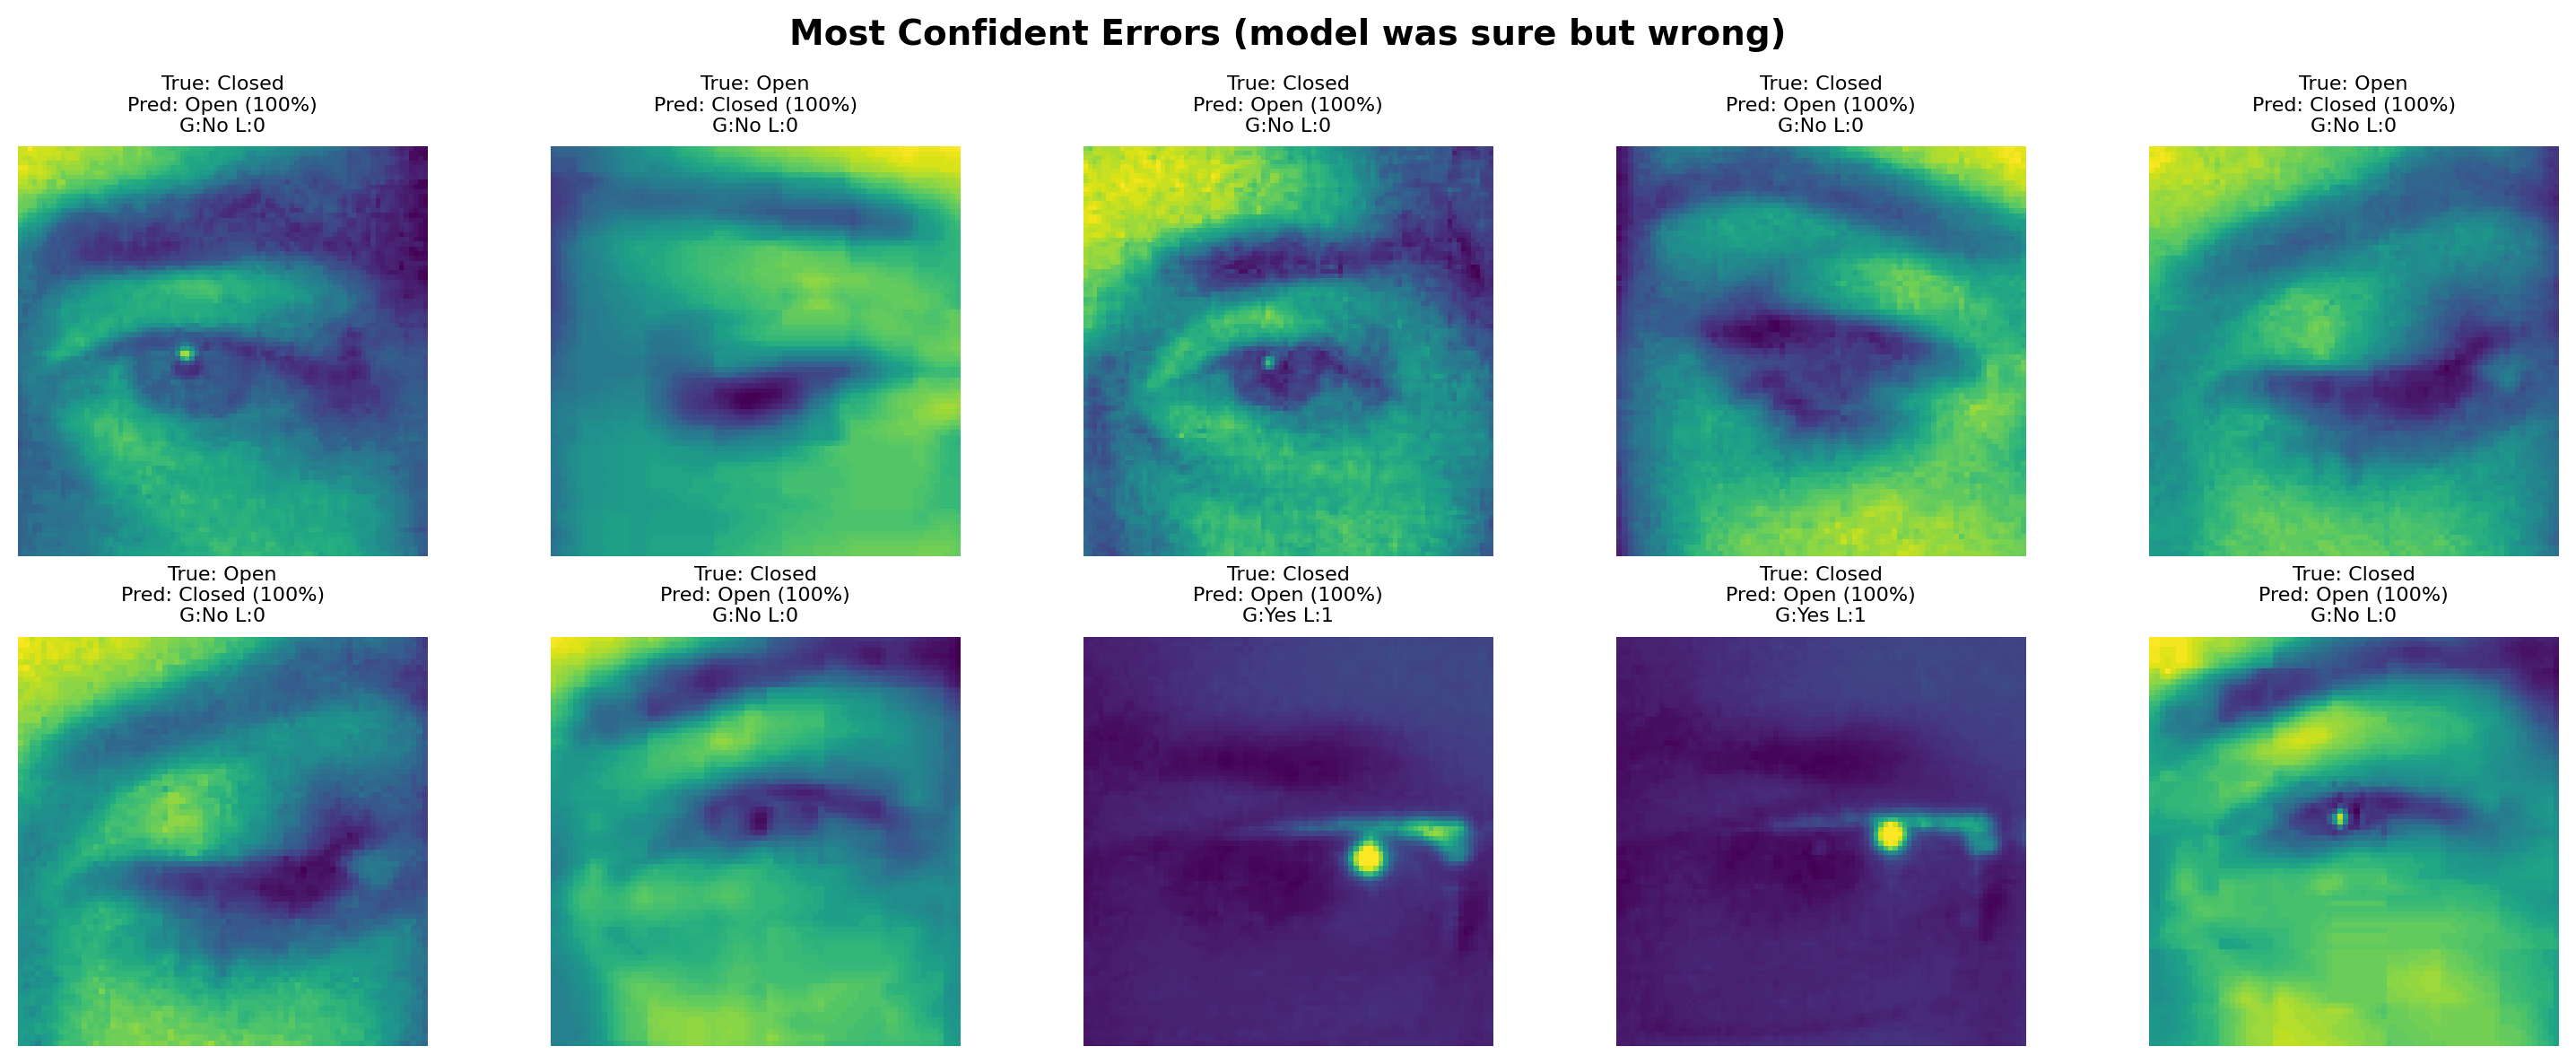

In [5]:
# Most confident errors (model was very sure but wrong)
errors['confidence'] = errors.apply(lambda r: r['prob_open'] if r['pred'] == 1 else 1 - r['prob_open'], axis=1)
confident_errors = errors.nlargest(10, 'confidence')
show_samples(confident_errors, 'Most Confident Errors (model was sure but wrong)')

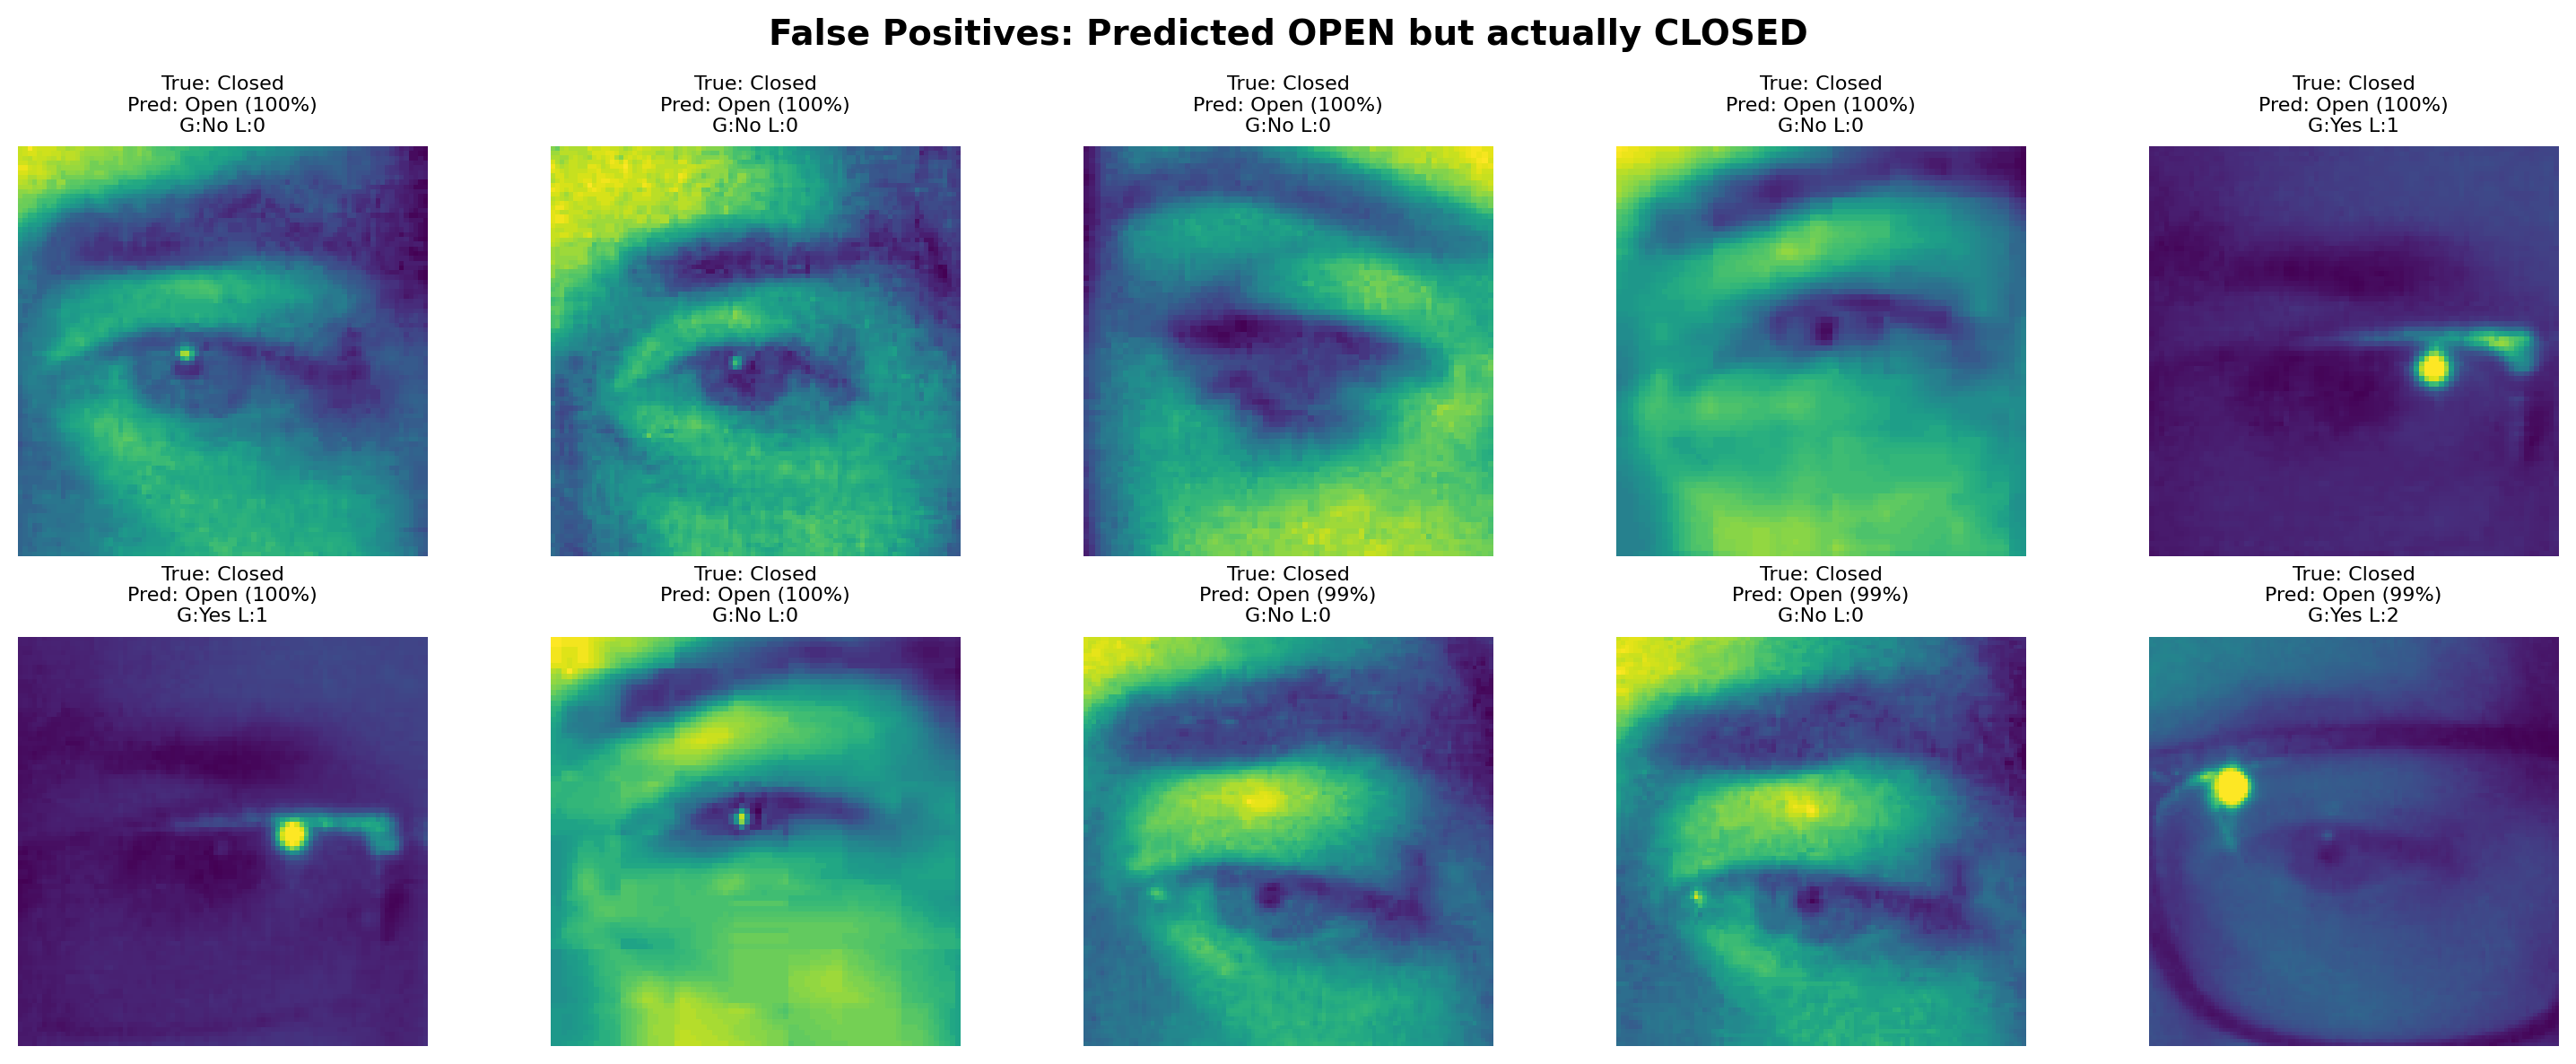

In [6]:
# False positives: predicted open but actually closed
fp = errors[errors['pred'] == 1].nlargest(10, 'confidence')
if len(fp) > 0:
    show_samples(fp, 'False Positives: Predicted OPEN but actually CLOSED')

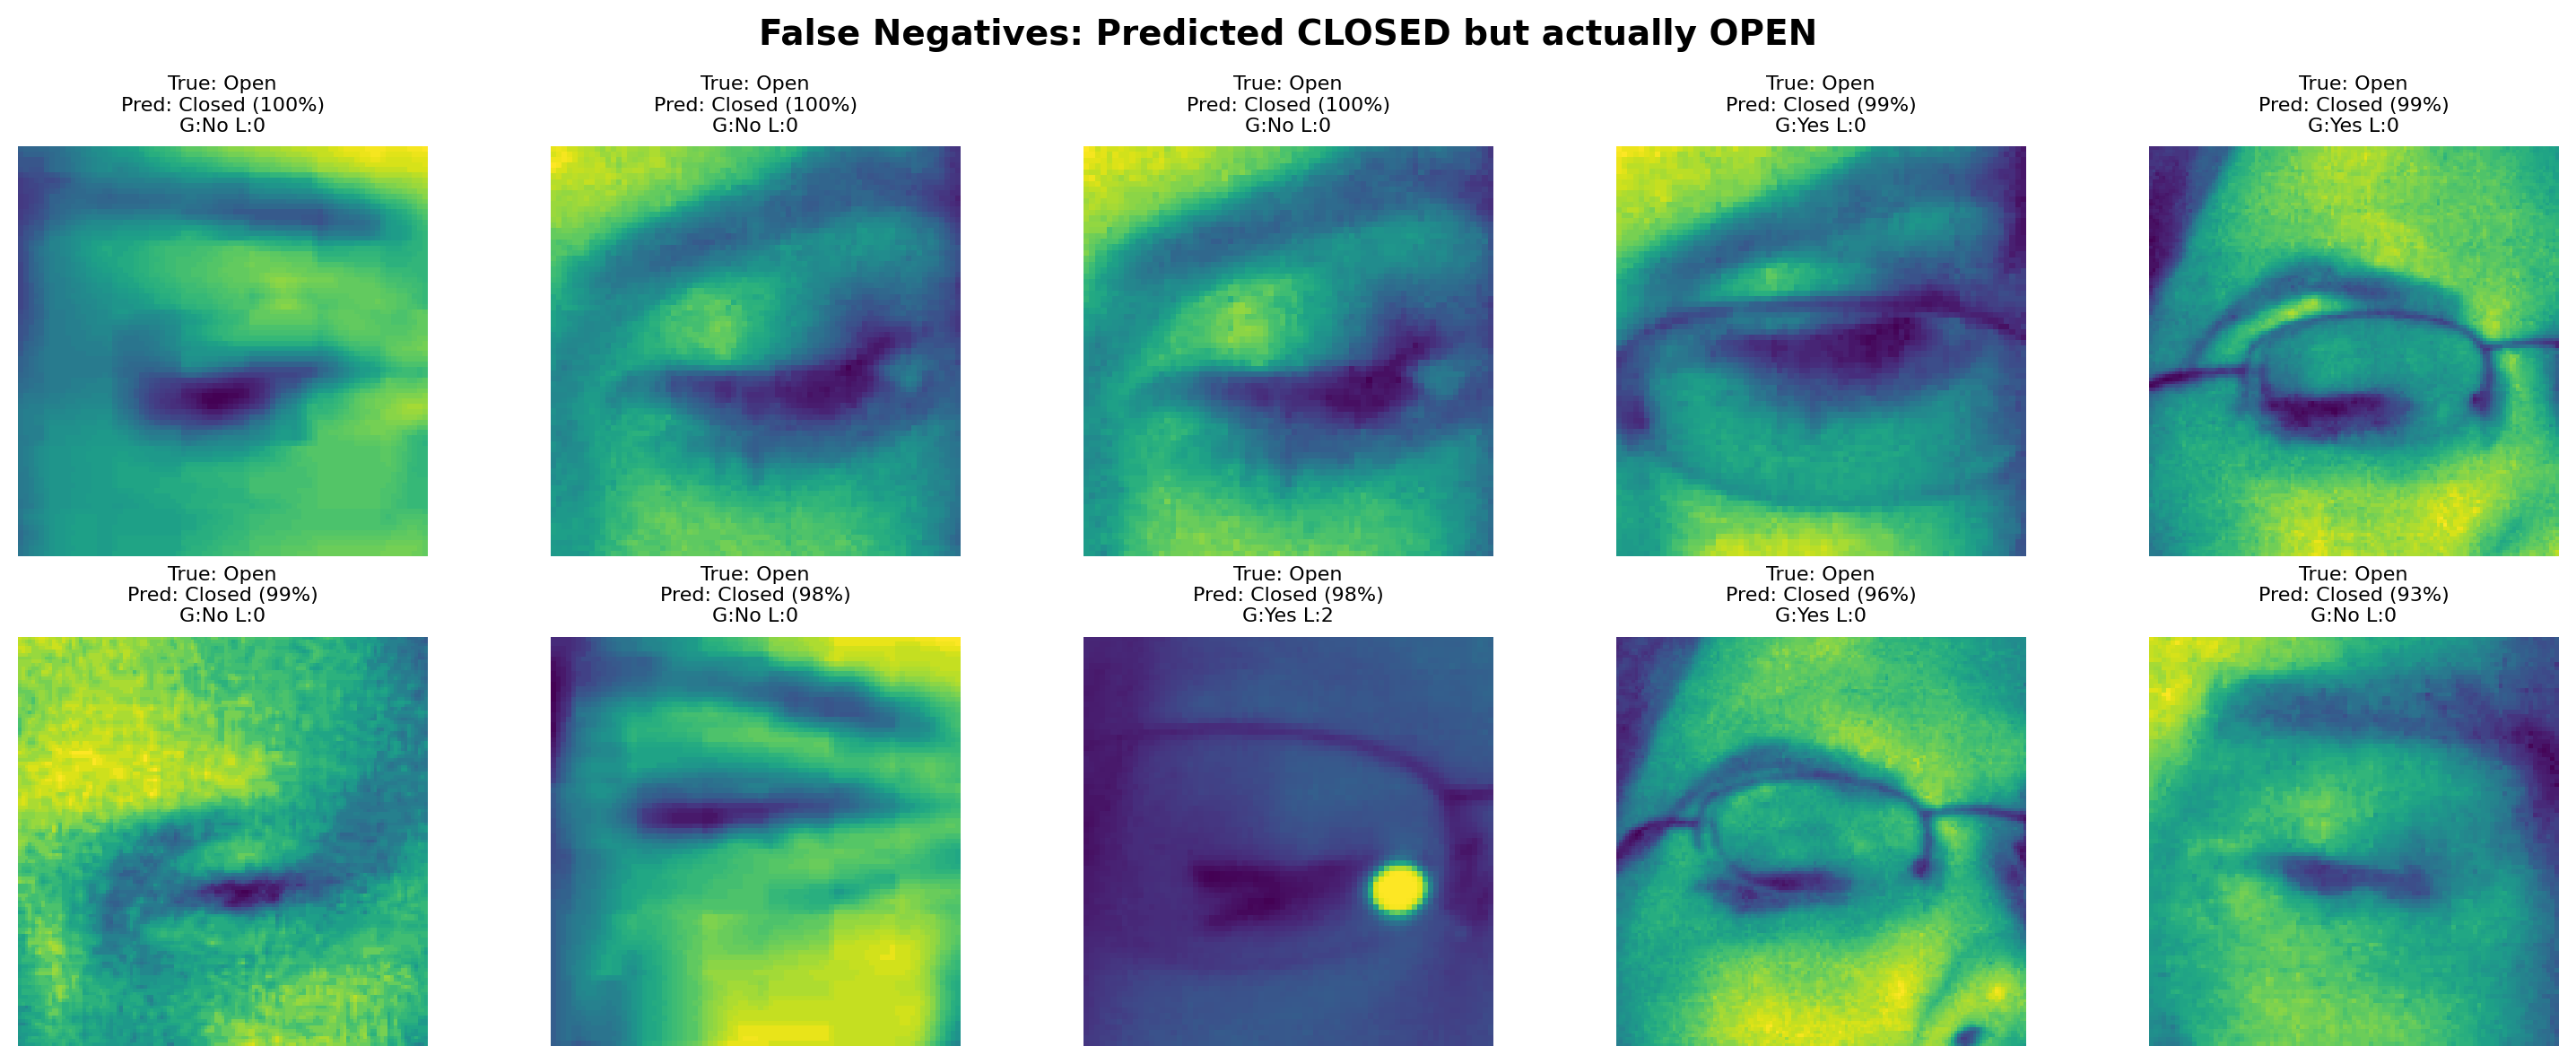

In [7]:
# False negatives: predicted closed but actually open
fn = errors[errors['pred'] == 0].nlargest(10, 'confidence')
if len(fn) > 0:
    show_samples(fn, 'False Negatives: Predicted CLOSED but actually OPEN')

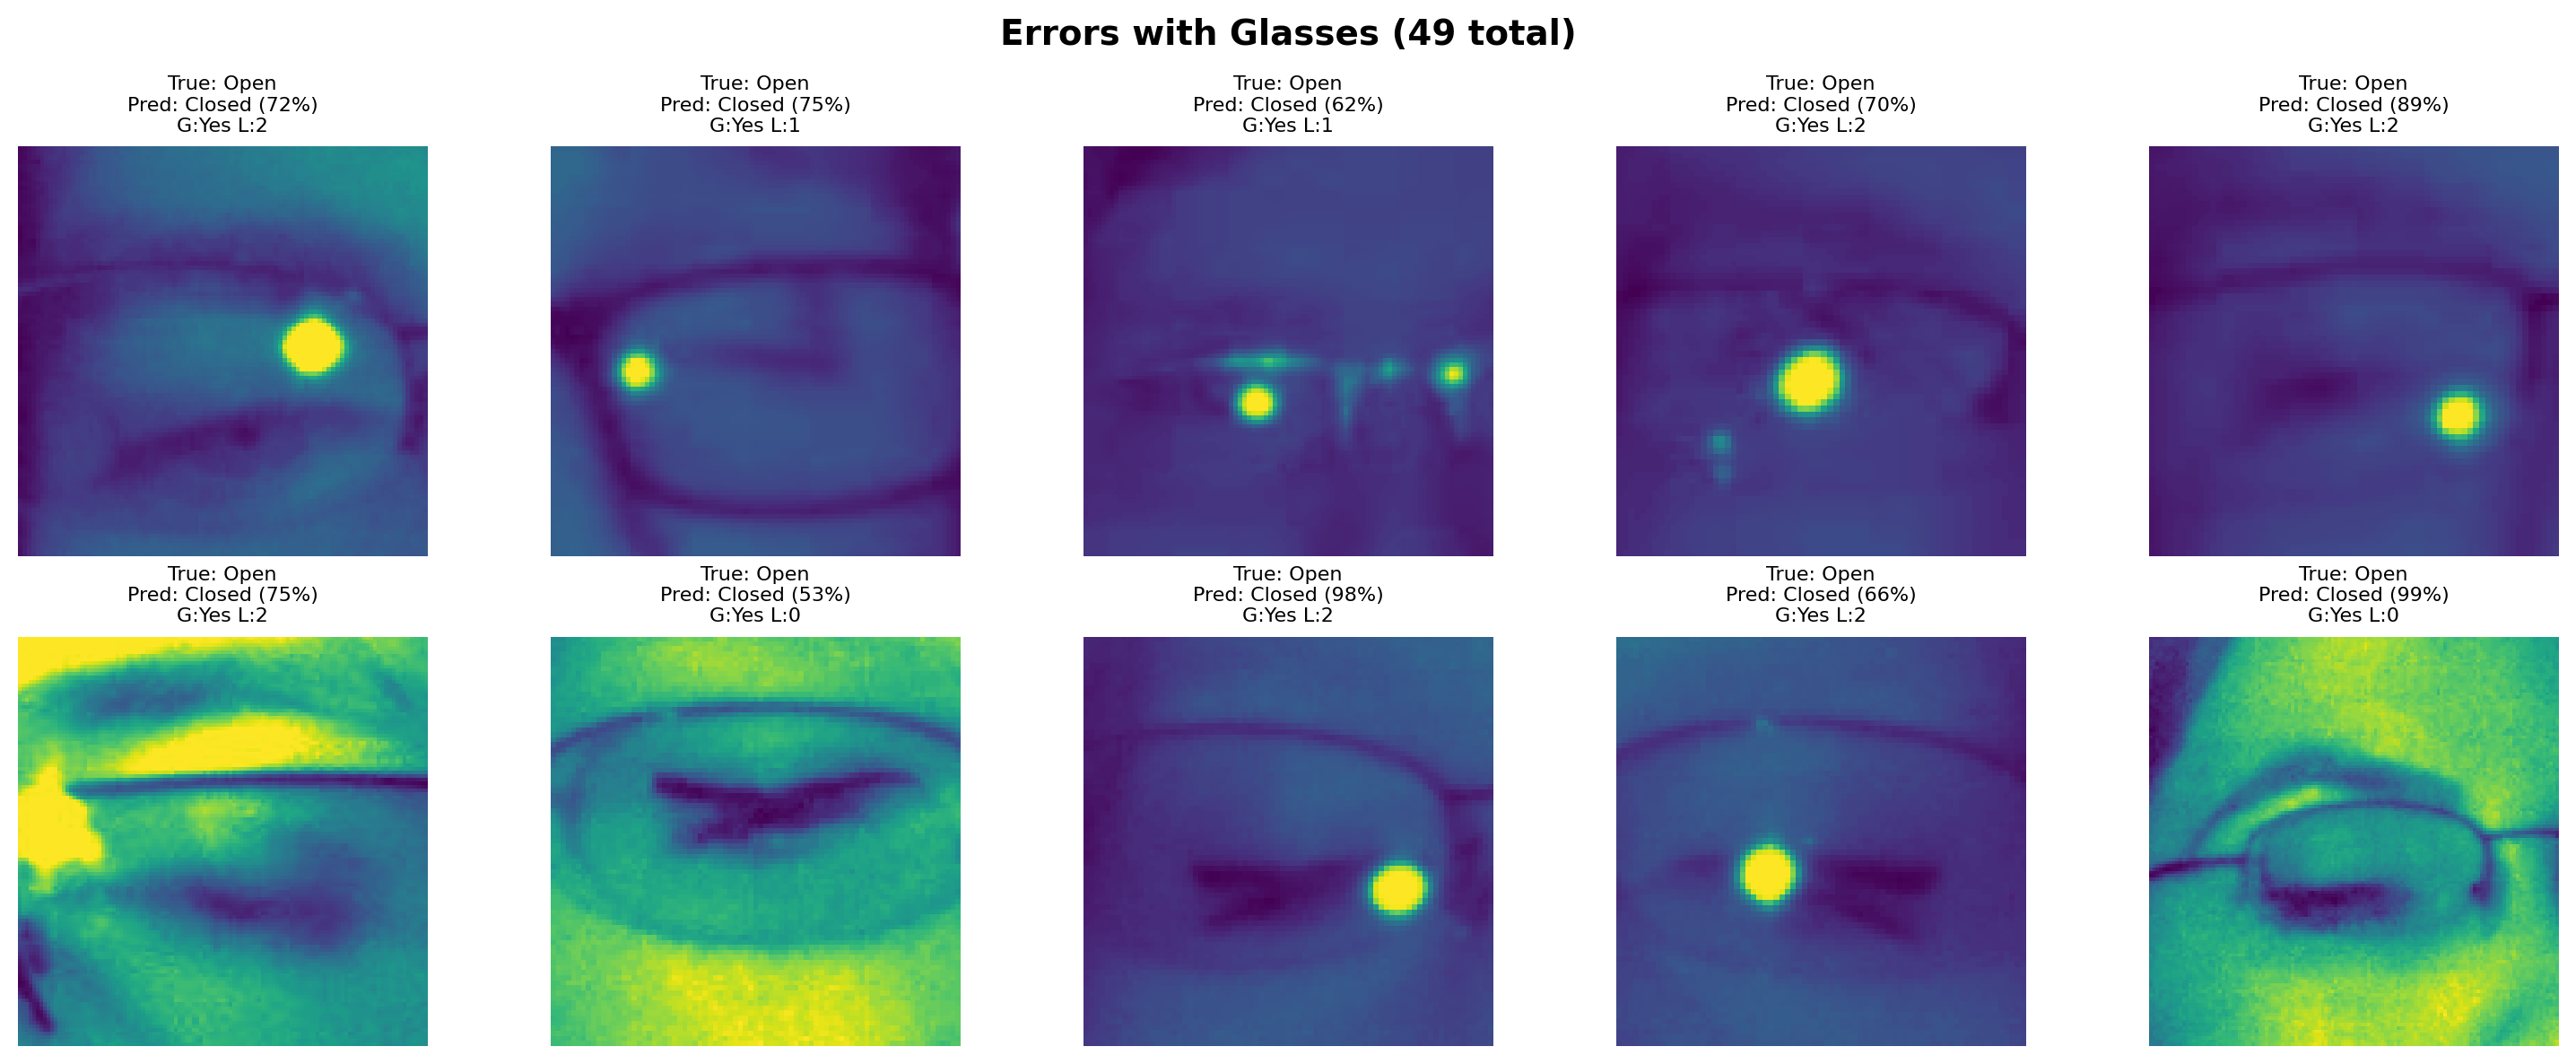

In [8]:
# Errors with glasses
glasses_errors = errors[errors['glasses'] == 'Yes'].head(10)
if len(glasses_errors) > 0:
    show_samples(glasses_errors, f'Errors with Glasses ({len(errors[errors["glasses"]=="Yes"])} total)')

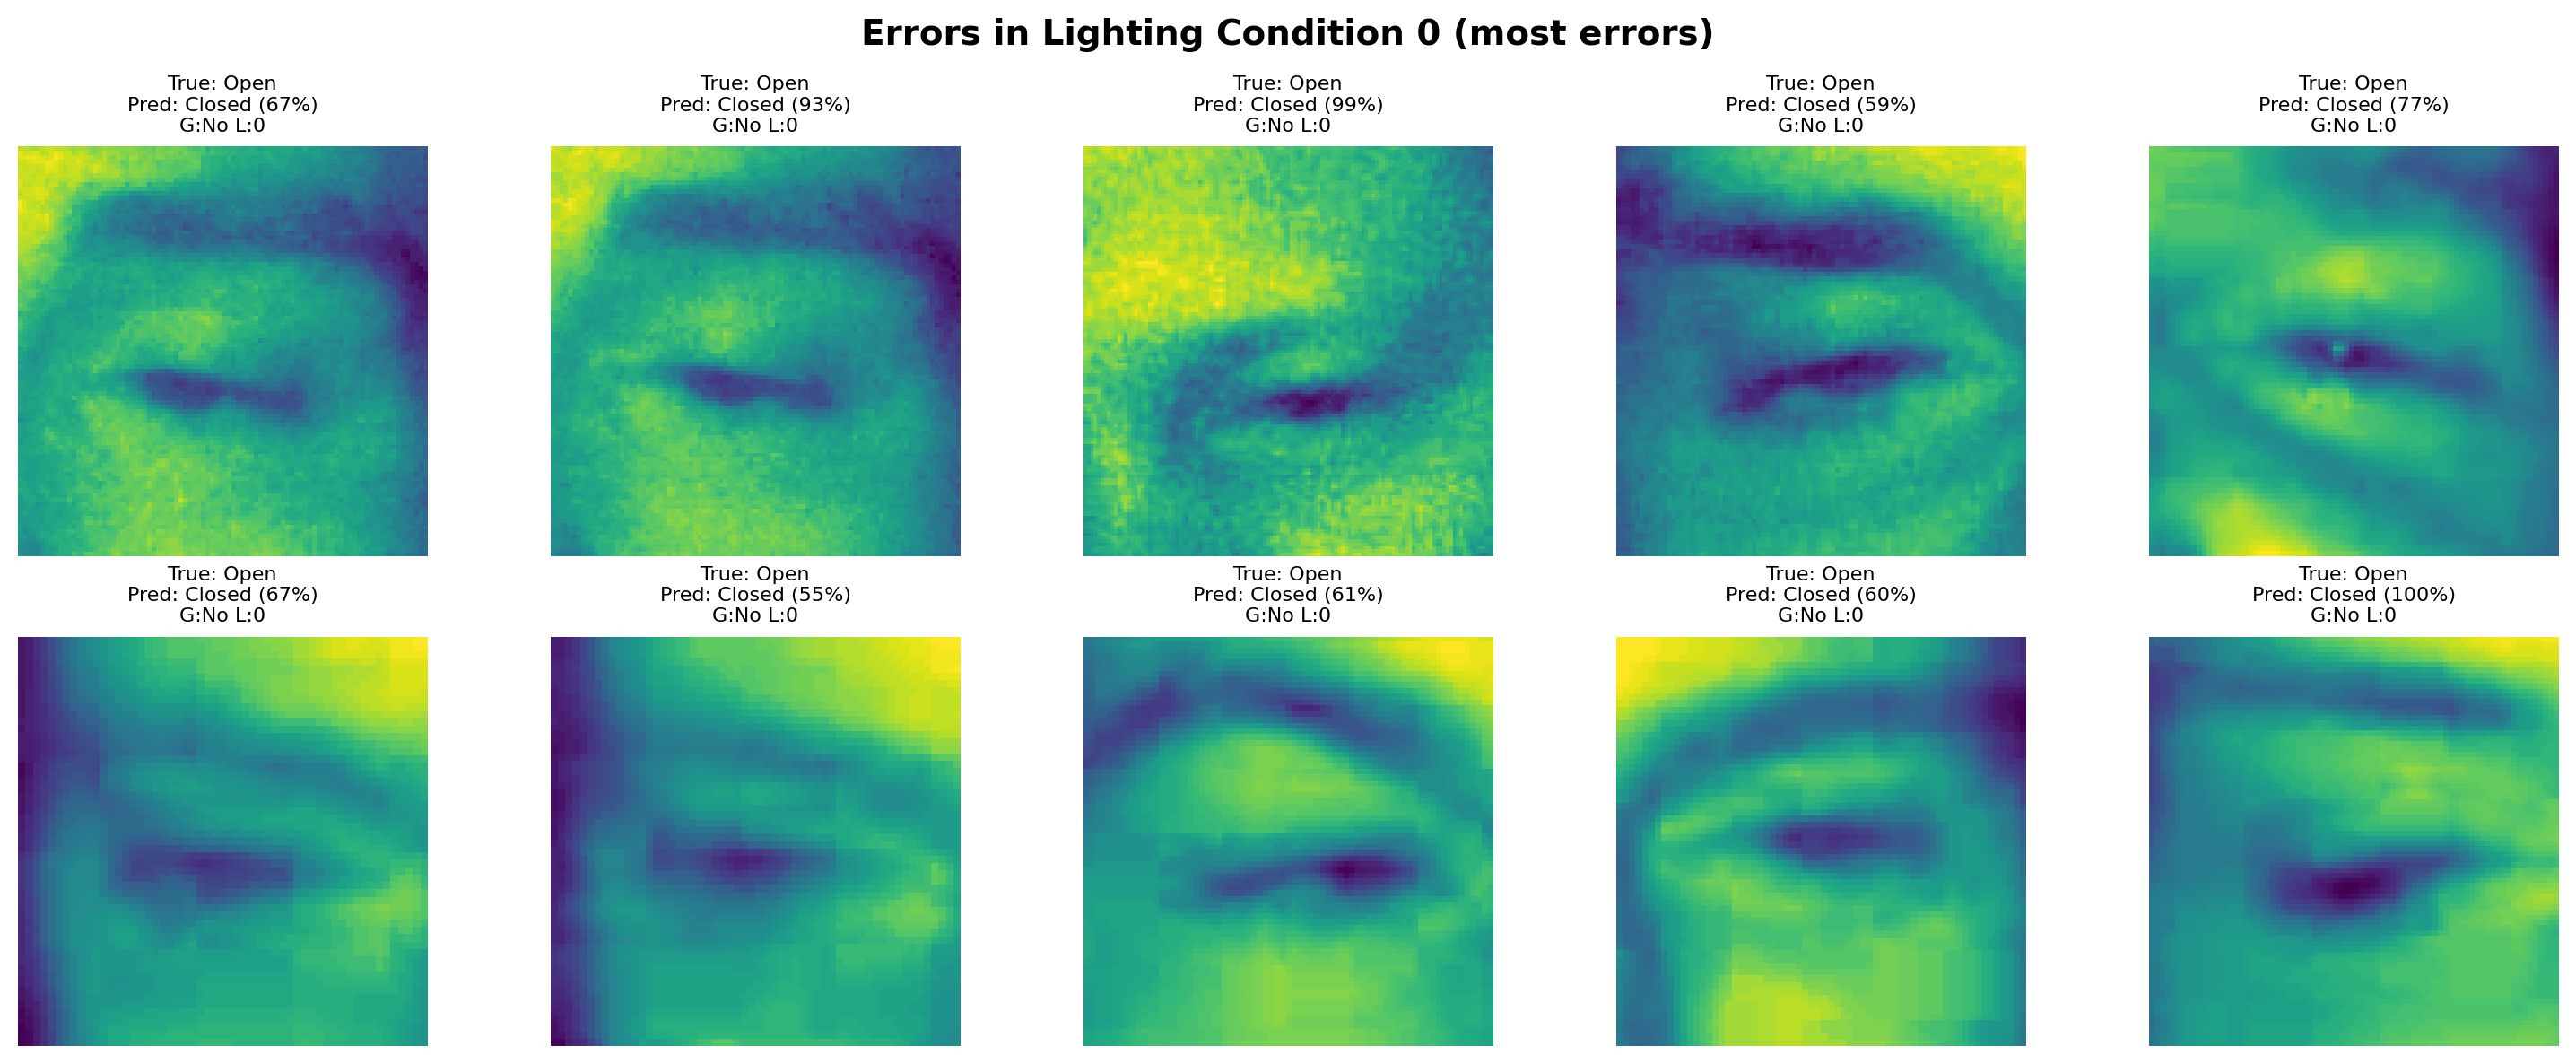

In [9]:
# Errors by lighting condition
worst_lighting = errors['lighting'].value_counts().idxmax()
lighting_errors = errors[errors['lighting'] == worst_lighting].head(10)
if len(lighting_errors) > 0:
    show_samples(lighting_errors, f'Errors in Lighting Condition {worst_lighting} (most errors)')

## Compare Correct vs Incorrect for Same Subject

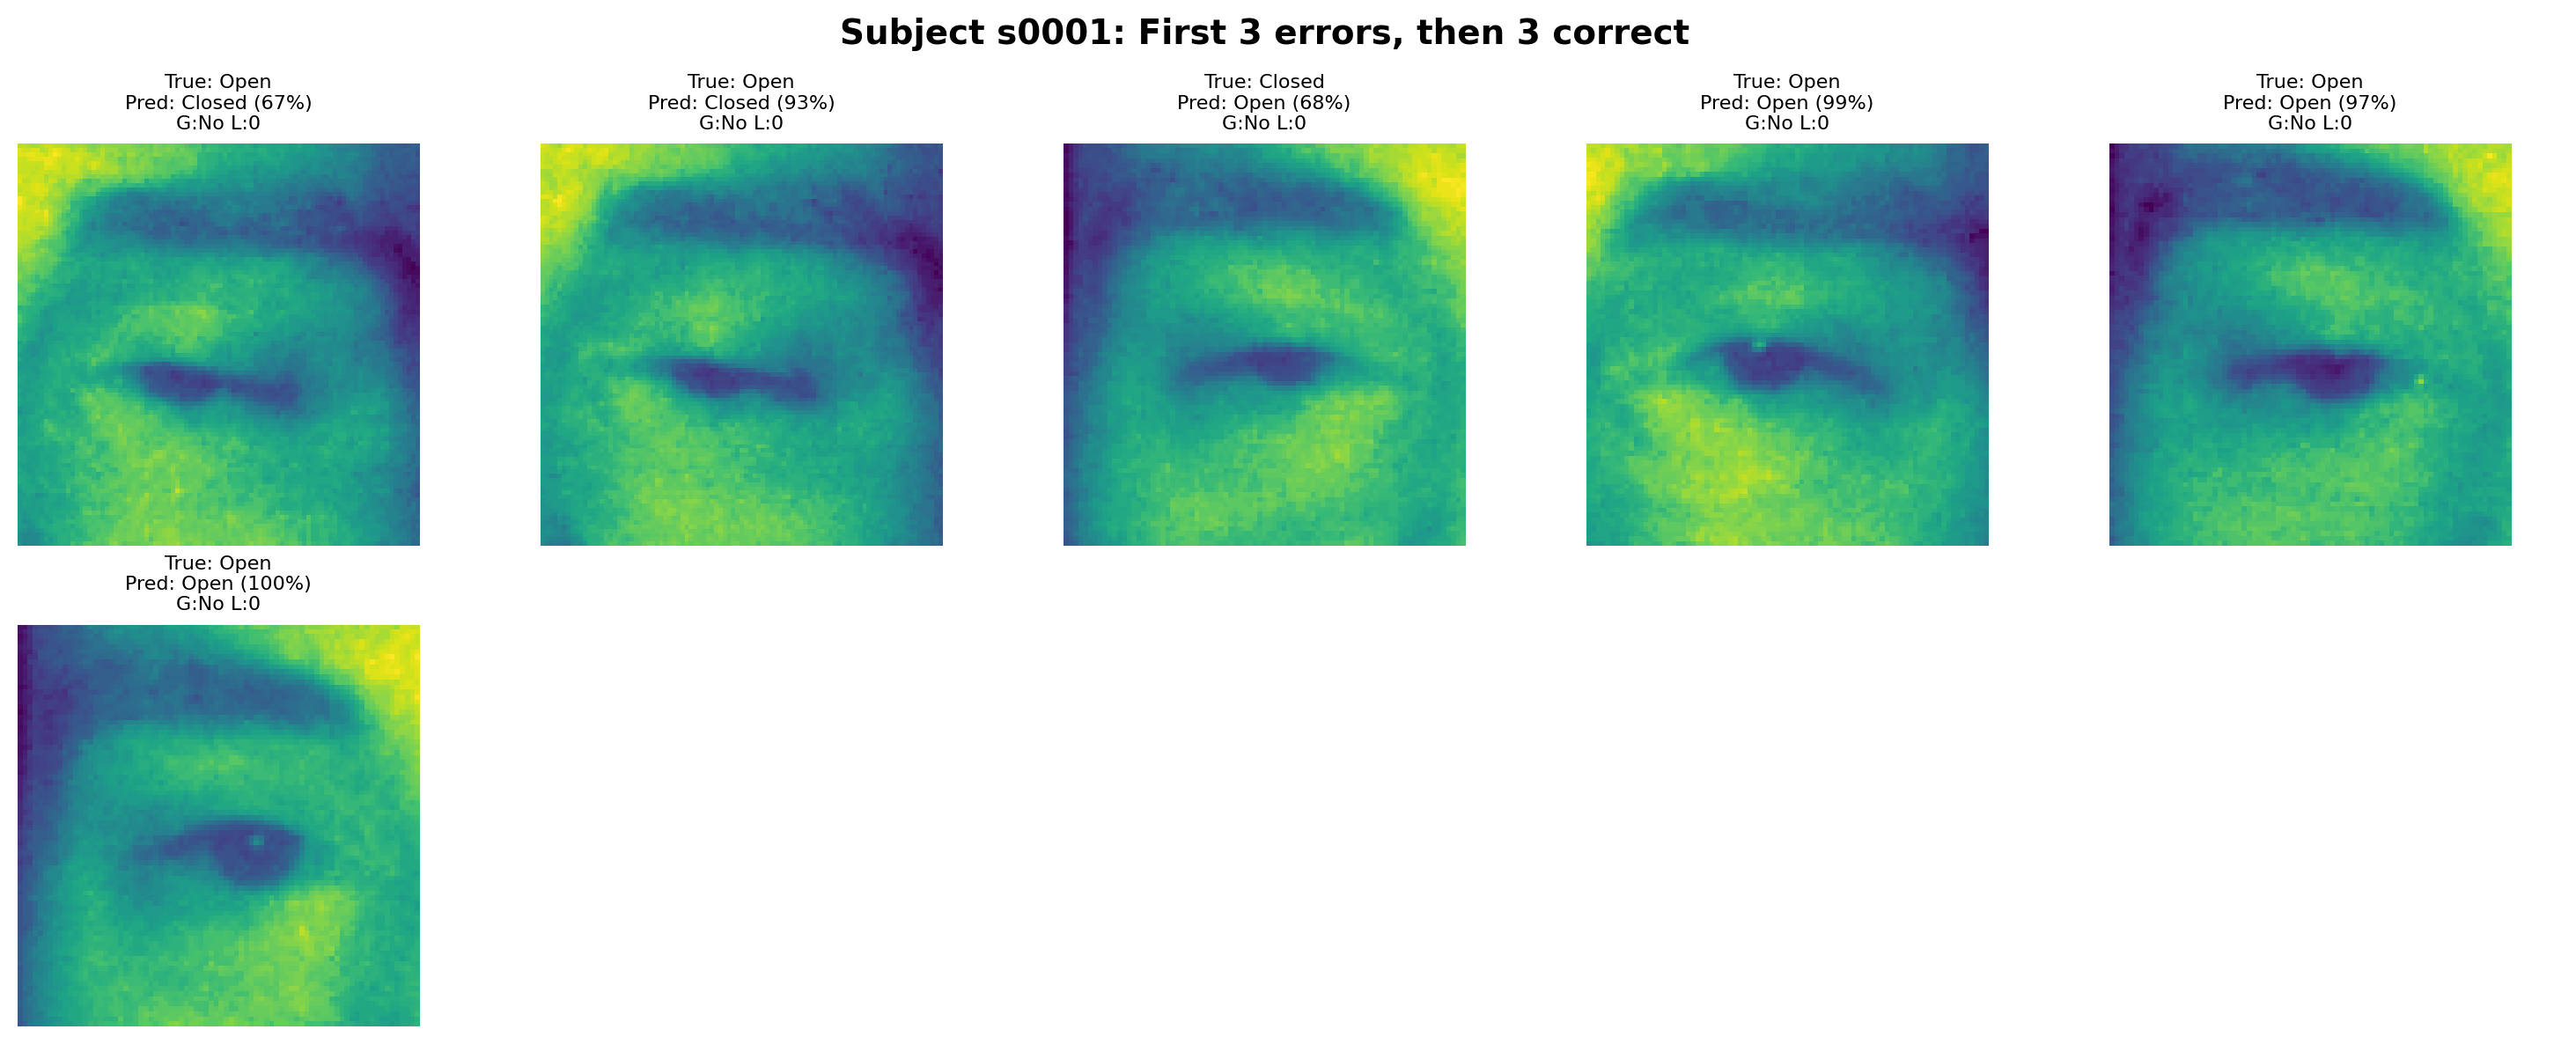

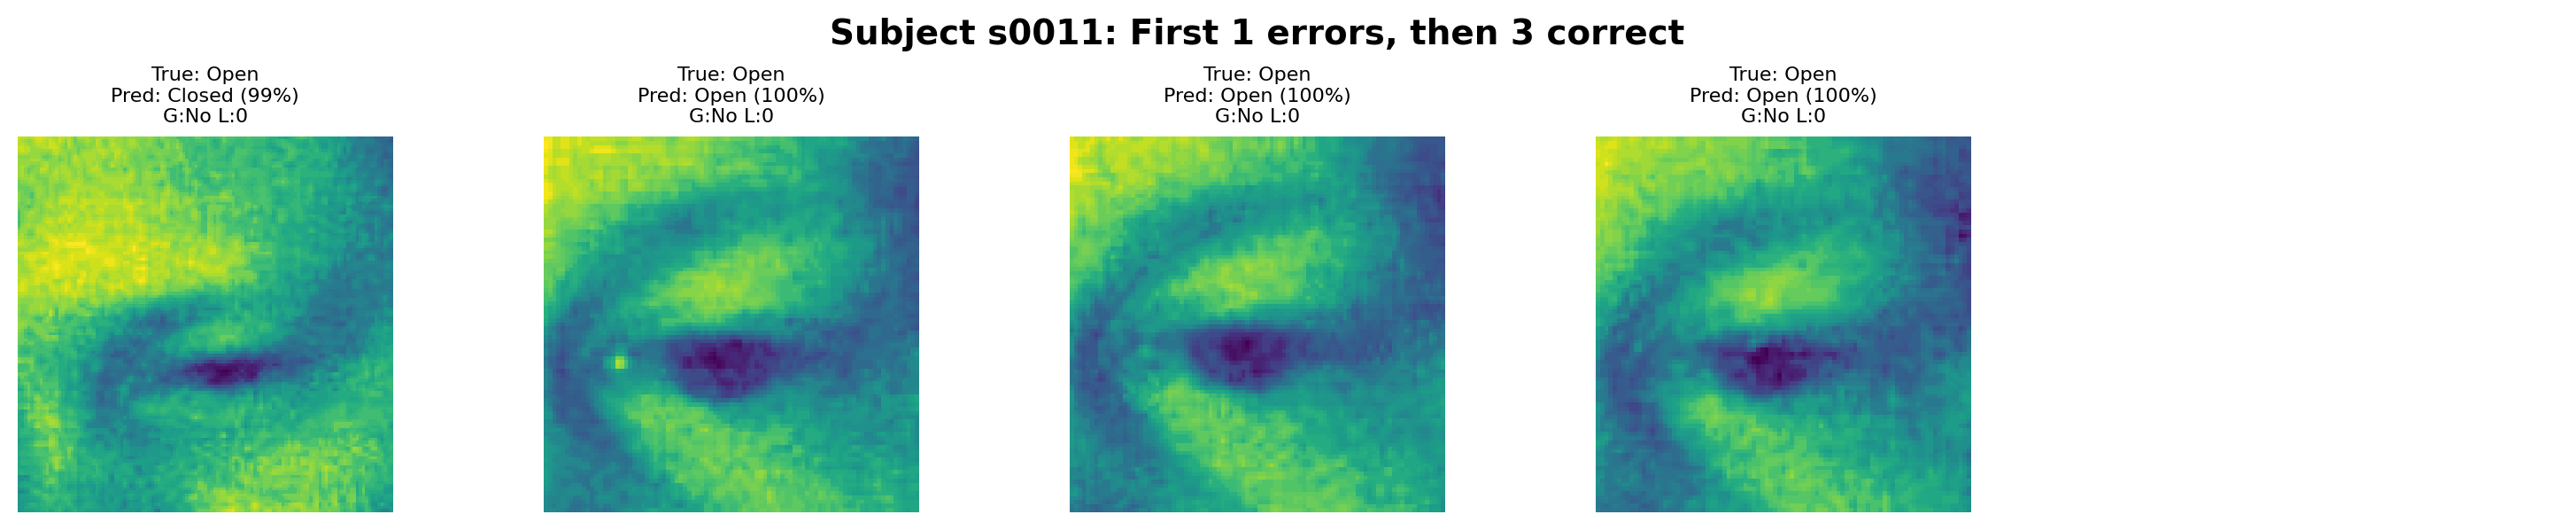

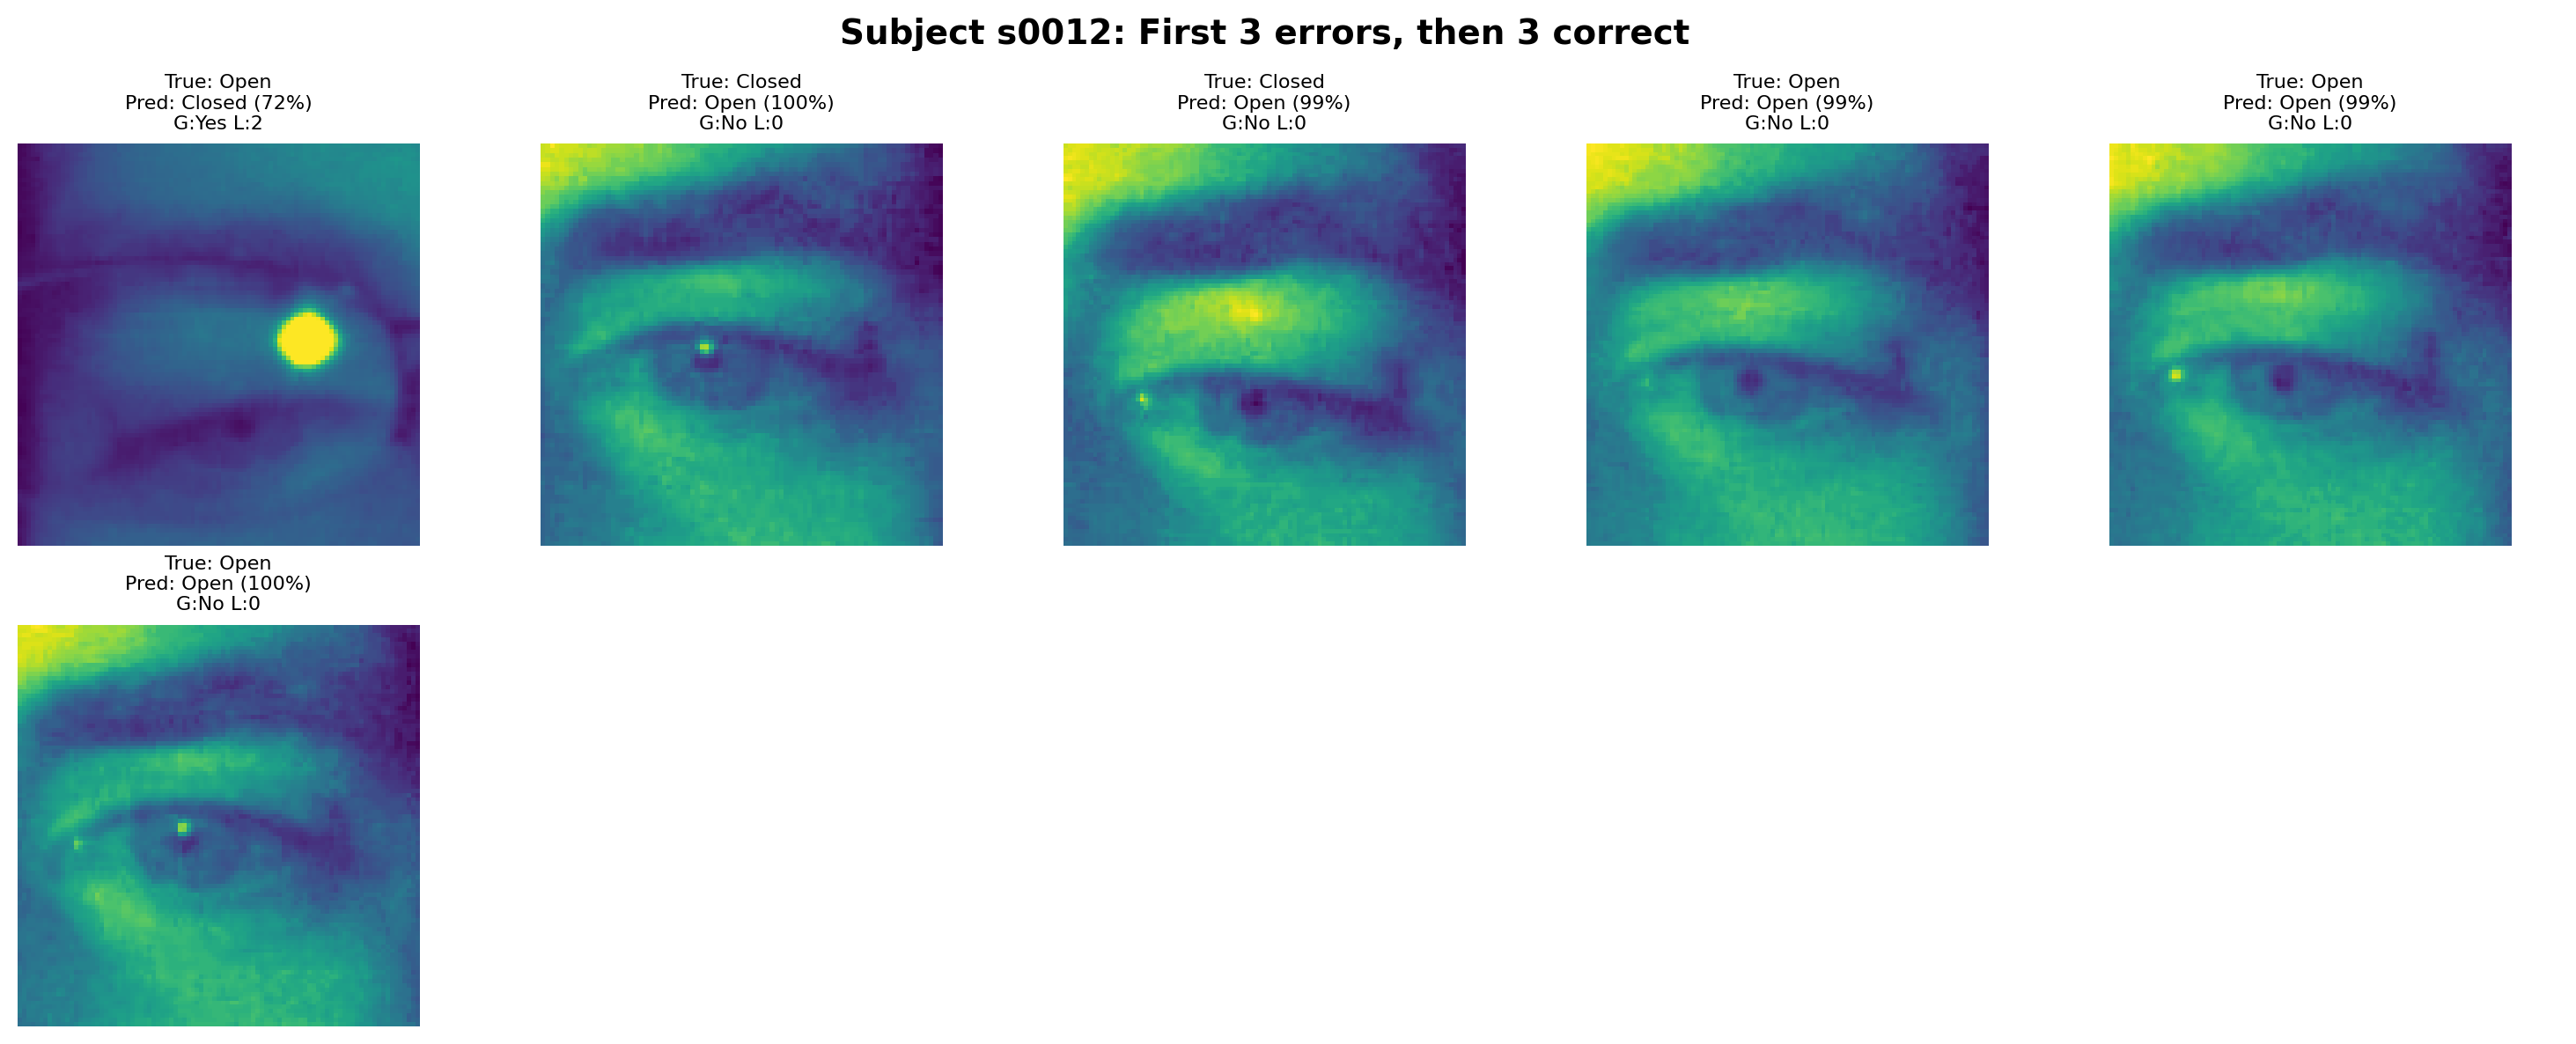

In [10]:
# Find subjects with both errors and correct predictions
error_subjects = errors['subject'].unique()
for subj in error_subjects[:3]:
    subj_df = df[df['subject'] == subj]
    subj_errors = subj_df[~subj_df['correct']].head(3)
    subj_correct = subj_df[subj_df['correct']].head(3)
    
    if len(subj_errors) > 0 and len(subj_correct) > 0:
        combined = pd.concat([subj_errors, subj_correct])
        show_samples(combined, f'Subject {subj}: First {len(subj_errors)} errors, then {len(subj_correct)} correct')